# Chronos - Basic Usage

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
my_ts_data.shape

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [ ]:
from chronos import Chronos

In [ ]:
my_chronos = Chronos(method="MAP", 
                     max_iter=1000, 
                     learning_rate=0.001,
                     distribution="StudentT", 
                     seasonality_mode="add")
my_chronos.fit(my_ts_data)

In [ ]:
future_df = my_chronos.make_future_dataframe(period=365)

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

In [ ]:
my_chronos.plot_components(predictions);

## Bike Sharing Data

Coming from Chicago: https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data?select=data.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [2]:
bike_data = pd.read_csv('data/data.csv')
bike_data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [3]:
relevant_data = bike_data[['starttime', 'trip_id']]
relevant_data['starttime'] = pd.to_datetime(relevant_data['starttime'])
relevant_data

<ipython-input-3-c947c196978f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['starttime'] = pd.to_datetime(relevant_data['starttime'])


,starttime,trip_id
0,2014-06-30 23:57:00,2355134
1,2014-06-30 23:56:00,2355133
2,2014-06-30 23:33:00,2355130
3,2014-06-30 23:26:00,2355129
4,2014-06-30 23:16:00,2355128
...,...,...
9495230,2017-10-01 00:01:00,16734072
9495231,2017-10-01 00:01:00,16734071
9495232,2017-10-01 00:01:00,16734070
9495233,2017-10-01 00:00:00,16734067


In [4]:
relevant_data['date'] = relevant_data['starttime'].dt.date
relevant_data.head()

<ipython-input-4-8522f6141ff6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['date'] = relevant_data['starttime'].dt.date


,starttime,trip_id,date
0,2014-06-30 23:57:00,2355134,2014-06-30
1,2014-06-30 23:56:00,2355133,2014-06-30
2,2014-06-30 23:33:00,2355130,2014-06-30
3,2014-06-30 23:26:00,2355129,2014-06-30
4,2014-06-30 23:16:00,2355128,2014-06-30


In [5]:
grouped_data = relevant_data.groupby('date').sum().reset_index()
grouped_data.columns = ['ds', 'y']
grouped_data['ds'] = pd.to_datetime(grouped_data['ds'])
grouped_data.head()

,ds,y
0,2014-01-01,105421324
1,2014-01-02,123221770
2,2014-01-03,6662107
3,2014-01-04,201035389
4,2014-01-05,35549270


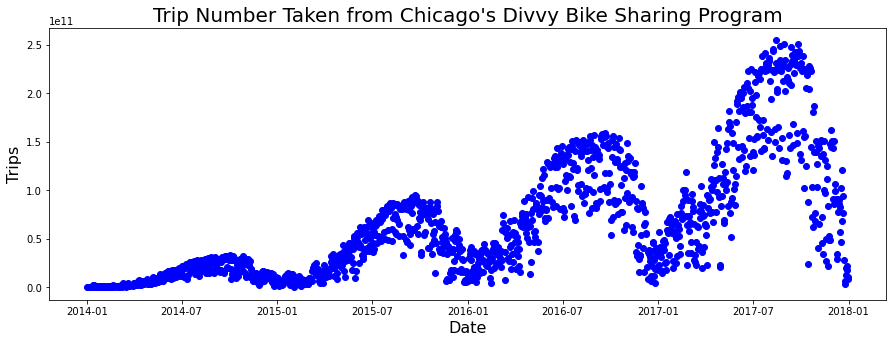

In [6]:
plt.figure(figsize=(15,5))
plt.scatter(grouped_data['ds'], grouped_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Trips", size=16)
plt.title(f"Trip Number Taken from Chicago's Divvy Bike Sharing Program", size=20)
plt.show()

In [11]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior=0.1,
                     distribution="Gamma",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.5884                                                                         


In [12]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=365)

In [13]:
#my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="Divvy components.png");

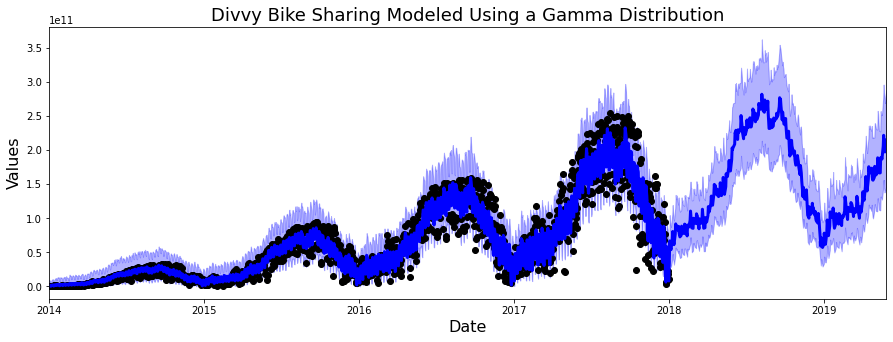

In [14]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
my_chronos.plot_predictions(predictions, fig, axs)
plt.title("Divvy Bike Sharing Modeled Using a Gamma Distribution", size=18)
plt.show();

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior=0.1,
                     distribution="Normal",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=365)

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
my_chronos.plot_predictions(predictions, fig, axs)
plt.title("Divvy Bike Sharing Modeled Using a Normal Distribution", size=18)
plt.show();

## COVID

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [ ]:
covid_data = pd.read_csv('data/covid19-download.csv')
covid_data.head(2)

In [ ]:
#canada_mask = covid_data['prname'] == 'British Columbia'
canada_mask = covid_data['prname'] == 'Alberta'
desired_columns = ['date', 'numtoday']

canada_daily_covid = covid_data[desired_columns].loc[canada_mask]
canada_daily_covid.head()

In [ ]:
canada_daily_covid.rename({'date': 'ds', 'numtoday': 'y'}, axis=1, inplace=True)
canada_daily_covid['ds'] = pd.to_datetime(canada_daily_covid['ds'])
#canada_daily_covid['y'] /= canada_daily_covid['y'].max()
canada_daily_covid = canada_daily_covid[canada_daily_covid['y']> 0]
canada_daily_covid.head()


In [ ]:
canada_daily_covid['y']

In [ ]:
canada_daily_covid['ds'].dt.day_name().isin(["Sunday", "Saturday"]).sum()/canada_daily_covid['ds'].shape[0]

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(canada_daily_covid['ds'], canada_daily_covid['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.001, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior=10.0,
                     distribution="Gamma",
                     seasonality_mode="mul",
                     year_seasonality_order=0,
                     weekly_seasonality_order=6,
                     month_seasonality_order=0)#, weekly_seasonality_order=0, month_seasonality_order=0)
my_chronos.fit(canada_daily_covid)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=30)

In [ ]:
my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="COVID components.png");

## AAPL stocks

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [ ]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MLE", max_iter=2000, 
                     learning_rate=0.0001, 
                     n_changepoints=25,
                     seasonality_mode="mul",
                     distribution="StudentT",
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

In [ ]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='B')
future_df

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

In [ ]:
my_chronos.plot_components(predictions, figure_name="AAPL.png", changepoint_threshold=0.3);